In [4]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


### Get Data

In [5]:
df = pd.read_csv('audio_data3.csv')

In [6]:
# Extract MFCC feature columns
X = df.iloc[:,6:].values

# Convert labels to numeric numbers 

#AUDIO DATA 1
# y = df["label"].map({"cat": 0, "dog_barking": 1}).values

# #AUDIO DATA 2
y = df["label"].map({"frog": 0,"donkey": 1,"cat": 2,"monkey": 3,"baby sheep": 4,"bird": 5,"lion": 6,"cow": 7,"dog": 8,"chicken": 9}).values
# label_s = ""
# count = 0
# for animal in list(set((df.iloc[:,3]))):
#     label_s += ",\""+animal+"\": "+ str(count)
#     count += 1
# print(label_s)

# Train-test split
# First split: train + val and test
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Second split: train and val
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42, stratify=y_train_val)

# Print the sizes of the splits
print(f'Training set size: {len(X_train)}')
print(f'Validation set size: {len(X_val)}')
print(f'Test set size: {len(X_test)}')

Training set size: 2106
Validation set size: 702
Test set size: 702


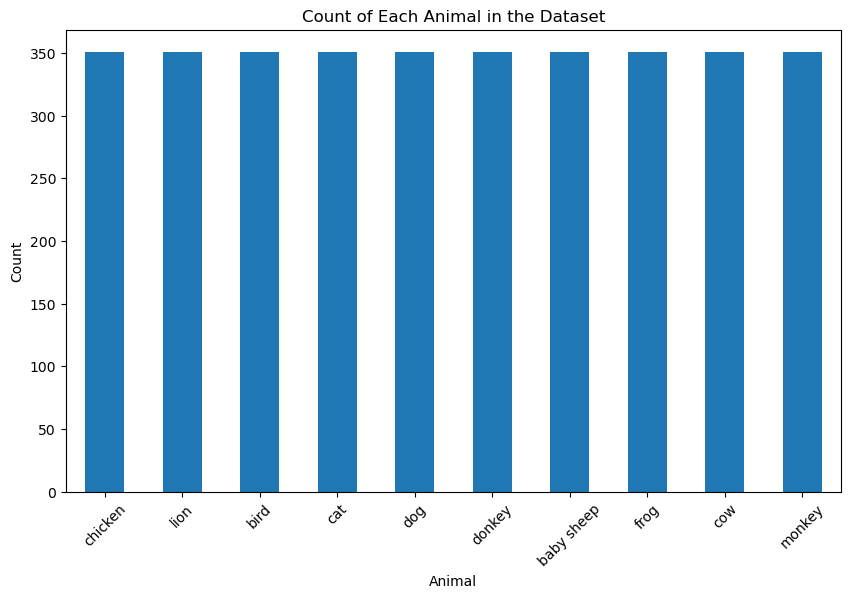

In [8]:
label_counts = df['label'].value_counts()

# Plot the histogram
plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.xlabel('Animal')
plt.ylabel('Count')
plt.title('Count of Each Animal in the Dataset')
plt.xticks(rotation=45)
plt.show()

In [9]:
def reshape_mfcc(mfcc_vector, height=37, width=36):
    padded = np.pad(mfcc_vector, (0, height * width - len(mfcc_vector)), mode='constant')
    return padded.reshape(height, width)

# Reshape all MFCC data
X_train = np.array([reshape_mfcc(x) for x in X_train])
X_val = np.array([reshape_mfcc(x) for x in X_val])
X_test = np.array([reshape_mfcc(x) for x in X_test])

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).unsqueeze(1)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).unsqueeze(1)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).unsqueeze(1)
y_train_tensor = torch.tensor(y_train, dtype=torch.long)
y_val_tensor = torch.tensor(y_val, dtype=torch.long)
y_test_tensor = torch.tensor(y_test, dtype=torch.long)


In [10]:
# Define Dataset class
class MFCCDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create datasets
train_dataset = MFCCDataset(X_train_tensor, y_train_tensor)
val_dataset = MFCCDataset(X_val_tensor, y_val_tensor)
test_dataset = MFCCDataset(X_test_tensor, y_test_tensor)

# Create dataloaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

### Create Model

In [44]:
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        
        # Define the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        
        # Define the output layer
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        if x.dim() == 4:
            x = x.squeeze(1)
        # Initialize hidden state with zeros
        h0 = torch.zeros(self.rnn.num_layers, x.size(0), self.rnn.hidden_size).to(x.device)
        
        # Forward pass through the RNN
        out, _ = self.rnn(x, h0)
        
        # Decode the hidden state of the last time step
        out = self.fc(out[:, -1, :])
        
        return out

# Hyperparameters
input_size = 33  # Size of the input features
hidden_size = 33 # Number of features in the hidden state
output_size = 2  # Size of the output (ADJUST FOR NUMBER OF CLASSES)
num_layers = 10 # Number of RNN layers




### Train Model

In [45]:
# Instantiate the RNN model
model = SimpleRNN(input_size, hidden_size, output_size, num_layers)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 100

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        
        optimizer.zero_grad()
        # inputs = inputs.squeeze(1)
        outputs = model(inputs)
        # outputs = outputs.squeeze(1)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")

print("Training complete!")


Epoch 1/100, Loss: 0.7107132502964565
Epoch 2/100, Loss: 0.668250458581107
Epoch 3/100, Loss: 0.619307313646589
Epoch 4/100, Loss: 0.5432794775281634
Epoch 5/100, Loss: 0.4875492623874119
Epoch 6/100, Loss: 0.4469206546034132
Epoch 7/100, Loss: 0.4252193868160248
Epoch 8/100, Loss: 0.39360468302454266
Epoch 9/100, Loss: 0.3592311314174107
Epoch 10/100, Loss: 0.3324012075151716
Epoch 11/100, Loss: 0.30285406538418363
Epoch 12/100, Loss: 0.26613542650427136
Epoch 13/100, Loss: 0.25179982823984964
Epoch 14/100, Loss: 0.21585396464381898
Epoch 15/100, Loss: 0.1904512345790863
Epoch 16/100, Loss: 0.16504622250795364
Epoch 17/100, Loss: 0.11275205122573036
Epoch 18/100, Loss: 0.10106290770428521
Epoch 19/100, Loss: 0.07641319424978324
Epoch 20/100, Loss: 0.08782308655125755
Epoch 21/100, Loss: 0.0733243211039475
Epoch 22/100, Loss: 0.054393548385373185
Epoch 23/100, Loss: 0.0468450840562582
Epoch 24/100, Loss: 0.014777212802852904
Epoch 25/100, Loss: 0.024166389501520565
Epoch 26/100, Loss: 

In [46]:
model.eval()
all_preds, all_labels = [], []

with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.numpy())
        all_labels.extend(labels.numpy())

accuracy = accuracy_score(all_labels, all_preds)
print(f"Test Accuracy: {accuracy}")


Test Accuracy: 0.7678571428571429


# Iterating Hyperparameters #

In [47]:
def full_model_evaluation(input_size, hidden_size, output_size, num_layers, training_loops):
    # Instantiate the RNN model
    model = SimpleRNN(input_size, hidden_size, output_size, num_layers)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)
    
    # Training loop
    num_epochs = 100
    
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
    
        for inputs, labels in train_loader:
            
            optimizer.zero_grad()
            # inputs = inputs.squeeze(1)
            outputs = model(inputs)
            # outputs = outputs.squeeze(1)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
    
        # print(f"Epoch {epoch+1}/{num_epochs}, Loss: {running_loss / len(train_loader)}")
    
    print("Training complete!")
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for inputs, labels in test_loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.numpy())
            all_labels.extend(labels.numpy())
    
    accuracy = accuracy_score(all_labels, all_preds)
    print(f"{(hidden_size, num_layers)}Test Accuracy: {accuracy}")
    return accuracy


In [50]:
test_accuracy = dict()
for hidden_size in range(15,46, 3): #ADJUST AS NEEDED
    for num_layers in range(1, 11): #ADJUST AS NEEDED
        model_accuracy = full_model_evaluation(input_size, hidden_size, output_size, num_layers, 100)
        test_accuracy[(hidden_size, num_layers)] = model_accuracy
print("ALL DONE")

Training complete!
(15, 1)Test Accuracy: 0.7142857142857143
Training complete!
(15, 2)Test Accuracy: 0.5892857142857143
Training complete!
(15, 3)Test Accuracy: 0.6964285714285714
Training complete!
(15, 4)Test Accuracy: 0.7321428571428571
Training complete!
(15, 5)Test Accuracy: 0.6785714285714286
Training complete!
(15, 6)Test Accuracy: 0.7321428571428571
Training complete!
(15, 7)Test Accuracy: 0.7321428571428571
Training complete!
(15, 8)Test Accuracy: 0.6071428571428571
Training complete!
(15, 9)Test Accuracy: 0.7857142857142857
Training complete!
(15, 10)Test Accuracy: 0.7678571428571429
Training complete!
(18, 1)Test Accuracy: 0.6607142857142857
Training complete!
(18, 2)Test Accuracy: 0.6785714285714286
Training complete!
(18, 3)Test Accuracy: 0.7142857142857143
Training complete!
(18, 4)Test Accuracy: 0.7321428571428571
Training complete!
(18, 5)Test Accuracy: 0.6964285714285714
Training complete!
(18, 6)Test Accuracy: 0.7142857142857143
Training complete!
(18, 7)Test Accuracy

In [49]:
best = max(test_accuracy, key=test_accuracy.get)
print("Best result is", best)
print(test_accuracy[best])
#BEST RESULT FOR DATASET 1 IS (33 hidden features, 10 layers)
#39, 5
#BEST RESULT FOR DATASET 2 IS (30 hidden features, 5 layers) = 0.8392857142857143

Best result is (39, 5)
0.8214285714285714
